In [ ]:
from google.colab import files
uploaded = files.upload()
# Just Pass on a file with two columns named Date-time, and Close, rest dont worry our algo will handle everything.

Saving Cross_Asset.csv to Cross_Asset.csv


Cross_Asset.csv: 782 rows retained


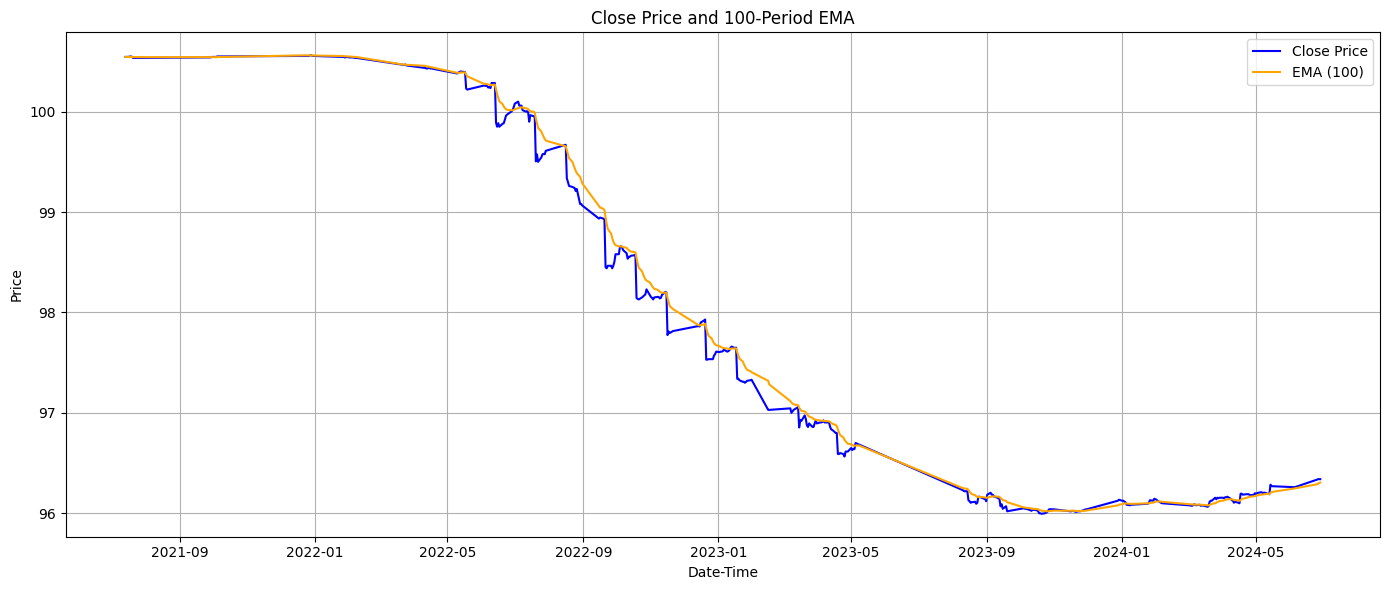

<ipython-input-8-3c980271626f>:215: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  recovery_idx = df[df.index > max_drawdown_idx][df['Cumulative_PnL'] >= running_max[max_drawdown_idx]]


=== Performance Summary ===
Total Trades: 38
Win Rate: 50.00%
Average Win: 0.2416
Average Loss: -0.0142
Expectancy: 0.1137
Average Trade PnL: 0.1163
Average Holding Time: 31604.21 minutes
Max Consecutive Wins: 3
Max Consecutive Losses: 2
Final tick wise profits: 4.42
Final Profit: 10,608.00 AUD
Maximum Drawdown: 0.06 ticks
Maximum Drawdown in AUD: 144.00
Maximum Drawdown Percentage: 1.35%
Drawdown Duration: 70560.00 minutes


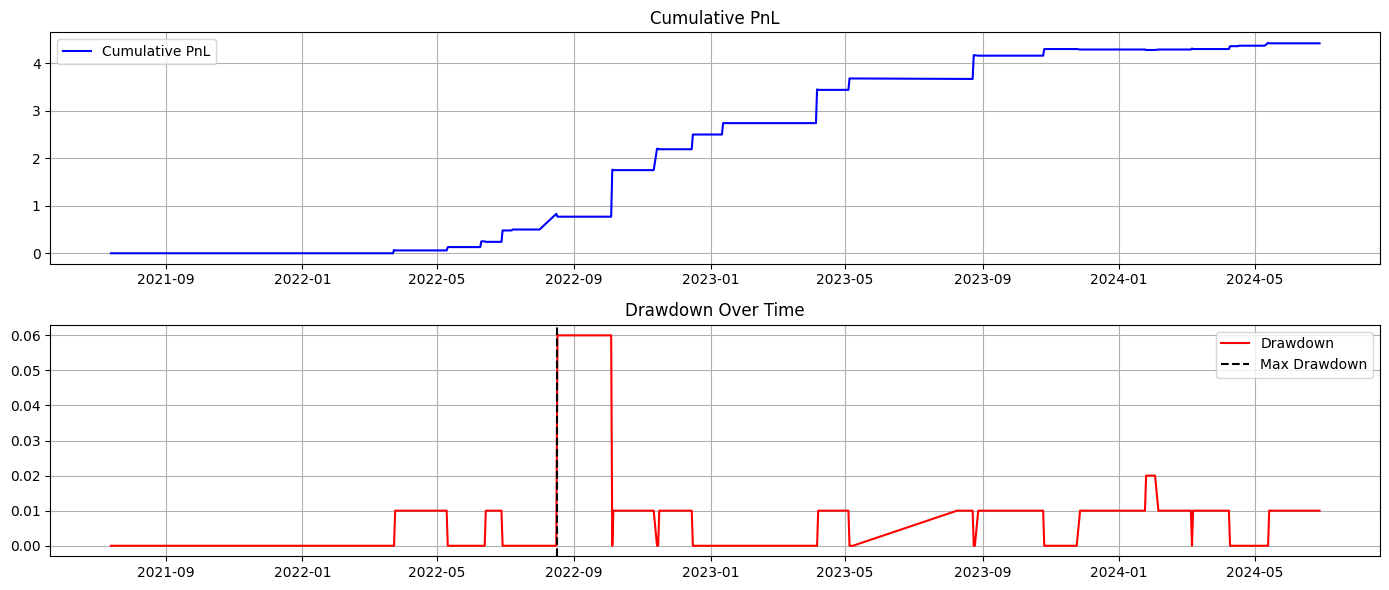

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

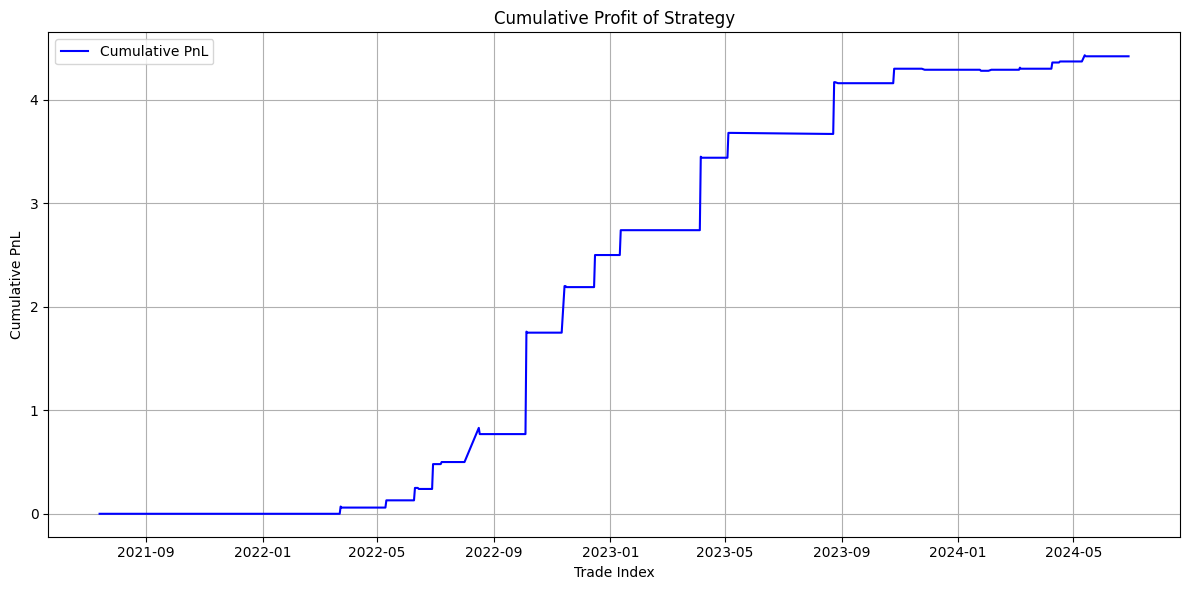

In [ ]:
import pandas as pd
from io import BytesIO

# Define date range (make it timezone-aware with UTC)
start_date = pd.Timestamp("2021-07-01", tz='UTC')
end_date = pd.Timestamp("2024-06-30 23:59:59", tz='UTC')


# Store filtered DataFrames
filtered_dfs = {}

# Process each uploaded file
for filename in uploaded:
    # Load CSV into DataFrame
    df = pd.read_csv(BytesIO(uploaded[filename]))

    # Convert 'Date-Time' column to datetime format
    df['Date-Time'] = pd.to_datetime(df['Date-Time'], utc=True)

    # Filter rows within the date range
    mask = (df['Date-Time'] >= start_date) & (df['Date-Time'] <= end_date)
    filtered_df = df.loc[mask]

    # Store the filtered DataFrame
    filtered_dfs[filename] = filtered_df

    # Optionally display number of rows kept
    print(f"{filename}: {len(filtered_df)} rows retained")
df=filtered_dfs['Cross_Asset.csv'].copy()
import pandas as pd

# Assuming df is already defined and has a DateTime index
# Step 1: Ensure 'Date-time' is a datetime object
df['Date-Time'] = pd.to_datetime(df['Date-Time'])

# Step 2: Set 'Date-time' as the index
df = df.set_index('Date-Time')
# Step 3: Resample to daily frequency and take the LAST close price in each day
df_d = df['Close '].resample('1D').last()

# Optional: Convert the Series back to a DataFrame
df_d = df_d.to_frame()
df=df_d.copy()
# Step 1: Make sure index is datetime (you likely already have this)
df.index = pd.to_datetime(df.index)

# Step 2: Remove weekends (Saturday=5, Sunday=6)
df = df[~df.index.dayofweek.isin([5, 6])]
df_d=df.copy()
df=df_d.copy()
df = df.reset_index()  # moves the index back to a column
df['Date-Time'] = pd.to_datetime(df['Date-Time'])
df.set_index('Date-Time', inplace=True)
df_2=df.copy()


import math

def backtest(df, tick_size=0.01, tick_value=24):
    df = df.copy()
    df['Position'] = 0
    df['Entry_Price'] = None
    df['PnL'] = 0.0
    df['Cumulative_PnL'] = 0.0

    trade_log = []
    position = 0
    entry_price = 0.0
    entry_time = None
    cumulative_pnl = 0.0

    for i in range(1, len(df)):
        price_prev = df['Close '].iloc[i - 1]
        ema_prev = df['EMA_20'].iloc[i - 1]
        price_now = df['Close '].iloc[i]
        ema_now = df['EMA_20'].iloc[i]
        std_now = df['Rolling_STD'].iloc[i]
        time_now = df.index[i]

        # === Exit Long ===
        if position == 1 and price_now < ema_now:
            exit_price = math.floor(ema_prev / tick_size) * tick_size # sell just below EMA
            pnl = exit_price - entry_price
            cumulative_pnl += pnl
            holding_time = (time_now - entry_time).total_seconds() / 60

            df.at[df.index[i], 'PnL'] = pnl
            df.at[df.index[i], 'Cumulative_PnL'] = cumulative_pnl
            trade_log.append({
                'Side': 'Long',
                'Entry Time': entry_time,
                'Exit Time': time_now,
                'Entry Price': entry_price,
                'Exit Price': exit_price,
                'PnL': pnl,
                'Holding Time (min)': holding_time
            })

            # Reverse to short
            if std_now > 0.005:
                entry_price = math.floor(ema_prev / tick_size) * tick_size # short just below EMA
                position = -1
                entry_time = time_now
                df.at[df.index[i], 'Entry_Price'] = entry_price
                df.at[df.index[i], 'Position'] = -1
            else:
                position = 0
                entry_price = 0
                entry_time = None

        # === Exit Short ===
        elif position == -1 and price_now > ema_now:
            exit_price = math.ceil(ema_prev / tick_size) * tick_size   # buy just above EMA
            pnl = entry_price - exit_price
            cumulative_pnl += pnl
            holding_time = (time_now - entry_time).total_seconds() / 60

            df.at[df.index[i], 'PnL'] = pnl
            df.at[df.index[i], 'Cumulative_PnL'] = cumulative_pnl
            trade_log.append({
                'Side': 'Short',
                'Entry Time': entry_time,
                'Exit Time': time_now,
                'Entry Price': entry_price,
                'Exit Price': exit_price,
                'PnL': pnl,
                'Holding Time (min)': holding_time
            })

            # Reverse to long
            if std_now > 0.005:
                entry_price = math.ceil(ema_prev / tick_size) * tick_size # long just above EMA
                position = 1
                entry_time = time_now
                df.at[df.index[i], 'Entry_Price'] = entry_price
                df.at[df.index[i], 'Position'] = 1
            else:
                position = 0
                entry_price = 0
                entry_time = None

        # === New Long Entry ===
        elif position == 0 and price_prev < ema_prev and price_now > ema_now and std_now > 0.005:
            entry_price = math.ceil(ema_prev / tick_size) * tick_size  # long just above EMA
            position = 1
            entry_time = time_now
            df.at[df.index[i], 'Entry_Price'] = entry_price
            df.at[df.index[i], 'Position'] = 1
            df.at[df.index[i], 'Cumulative_PnL'] = cumulative_pnl

        # === New Short Entry ===
        elif position == 0 and price_prev > ema_prev and price_now < ema_now and std_now > 0.005:
            entry_price = math.floor(ema_prev / tick_size) * tick_size  # short just below EMA
            position = -1
            entry_time = time_now
            df.at[df.index[i], 'Entry_Price'] = entry_price
            df.at[df.index[i], 'Position'] = -1
            df.at[df.index[i], 'Cumulative_PnL'] = cumulative_pnl

        else:
            df.at[df.index[i], 'Position'] = position
            df.at[df.index[i], 'Cumulative_PnL'] = cumulative_pnl

    trade_df = pd.DataFrame(trade_log)
    trade_df.to_csv('sofr_trade_log.csv', index=False)

    return df, trade_df

import matplotlib.pyplot as plt

def performance(df, trade_log, tick_value):
    if len(trade_log) == 0:
        print("No trades to analyze.")
        return

    wins = trade_log[trade_log['PnL'] > 0]
    losses = trade_log[trade_log['PnL'] < 0]

    win_rate = len(wins) / len(trade_log)
    avg_win = wins['PnL'].mean() if not wins.empty else 0
    avg_loss = losses['PnL'].mean() if not losses.empty else 0
    expectancy = win_rate * avg_win + (1 - win_rate) * avg_loss
    avg_trade_pnl = trade_log['PnL'].mean()
    avg_holding_time = trade_log['Holding Time (min)'].mean()
    total_trades = len(trade_log)

    # Consecutive wins/losses
    pnl_signs = trade_log['PnL'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    max_consec_win, max_consec_loss = 0, 0
    current_win, current_loss = 0, 0

    for s in pnl_signs:
        if s > 0:
            current_win += 1
            max_consec_win = max(max_consec_win, current_win)
            current_loss = 0
        elif s < 0:
            current_loss += 1
            max_consec_loss = max(max_consec_loss, current_loss)
            current_win = 0
        else:
            current_win = current_loss = 0

    final_cumulative_pnl = df['Cumulative_PnL'].iloc[-1]
    final_profit = final_cumulative_pnl * 100 * tick_value

    # === Drawdown Calculations ===
    running_max = df['Cumulative_PnL'].cummax()
    drawdowns = running_max - df['Cumulative_PnL']
    max_drawdown = drawdowns.max()
    max_drawdown_pct = (max_drawdown / running_max.max()) * 100 if running_max.max() != 0 else 0
    max_drawdown_idx = drawdowns.idxmax()

    # Identify drawdown recovery
    recovery_idx = df[df.index > max_drawdown_idx][df['Cumulative_PnL'] >= running_max[max_drawdown_idx]]
    if not recovery_idx.empty:
        drawdown_end_time = recovery_idx.index[0]
        drawdown_duration = (drawdown_end_time - max_drawdown_idx).total_seconds() / 60  # in minutes
    else:
        drawdown_duration = None  # not recovered yet

    print("=== Performance Summary ===")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate * 100:.2f}%")
    print(f"Average Win: {avg_win:.4f}")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Expectancy: {expectancy:.4f}")
    print(f"Average Trade PnL: {avg_trade_pnl:.4f}")
    print(f"Average Holding Time: {avg_holding_time:.2f} minutes")
    print(f"Max Consecutive Wins: {max_consec_win}")
    print(f"Max Consecutive Losses: {max_consec_loss}")
    print(f"Final tick wise profits: {final_cumulative_pnl:,.2f}")
    print(f"Final Profit: {final_profit:,.2f} AUD")
    print(f"Maximum Drawdown: {max_drawdown:.2f} ticks")
    print(f"Maximum Drawdown in AUD: {max_drawdown * 100 * tick_value:.2f}")
    print(f"Maximum Drawdown Percentage: {max_drawdown_pct:.2f}%")
    if drawdown_duration is not None:
        print(f"Drawdown Duration: {drawdown_duration:.2f} minutes")
    else:
        print("Drawdown not yet recovered")

    # === Plot Cumulative PnL & Drawdown ===
    plt.figure(figsize=(14, 6))

    # Plot cumulative PnL
    plt.subplot(2, 1, 1)
    plt.plot(df['Cumulative_PnL'], label='Cumulative PnL', color='blue')
    plt.title("Cumulative PnL")
    plt.grid(True)
    plt.legend()

    # Plot drawdown
    plt.subplot(2, 1, 2)
    plt.plot(drawdowns, label='Drawdown', color='red')
    plt.axvline(x=max_drawdown_idx, color='black', linestyle='--', label='Max Drawdown')
    plt.title("Drawdown Over Time")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
import pandas as pd
import matplotlib.pyplot as plt

def ema(df):
    if 'Date-Time' in df.columns:
        df['Date-Time'] = pd.to_datetime(df['Date-Time'])
        df.set_index('Date-Time', inplace=True)

    df['EMA_20'] = df['Close '].ewm(span=15, adjust=False).mean()
    df['Rolling_STD'] = df['Close '].rolling(window=10).std()
    df.dropna(inplace=True)

    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['Close '], label='Close Price', color='blue')
    plt.plot(df.index, df['EMA_20'], label='EMA (100)', color='orange')
    plt.title('Close Price and 100-Period EMA')
    plt.xlabel('Date-Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df

def Analysis(df_2, tick_size=0.01, tick_value=24):
    df_2 = ema(df_2)
    df_2, trade_log = backtest(df_2, tick_size, tick_value)
    performance(df_2, trade_log,tick_value)

    return df_2, trade_log
df_1,trade_log=Analysis(df_2, tick_size=0.01, tick_value=24)
trade_log.to_csv('trade_log.csv', index=False)
from google.colab import files
files.download('trade_log.csv')
# Save the DataFrame to a CSV file
df_1.to_csv('df.csv', index=False)

# Download the CSV file to your computer
from google.colab import files
files.download('df.csv')


import matplotlib.pyplot as plt

# Plot cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(df_1['Cumulative_PnL'], label='Cumulative PnL', color='blue')
plt.title('Cumulative Profit of Strategy')
plt.xlabel('Trade Index')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Ensure 'Date' is the index for time-based operations
df_filtered.set_index('Date-Time', inplace=True)

# Step 1: Resample to daily frequency and forward-fill missing data
df_daily = df_filtered.resample('D').ffill()

# Step 2: Remove weekends (Saturday = 5, Sunday = 6)
df_weekdays = df_daily[~df_daily.index.weekday.isin([5, 6])]

# Step 3: Reset index if needed (optional)
df_weekdays.reset_index(inplace=True)

# Show the result
print(df_weekdays.head())
print(f"\nTotal rows after resampling and removing weekends: {len(df_weekdays)}")


   Date-Time    Close
0 2020-01-02      NaN
1 2020-01-03  100.390
2 2020-01-06  100.390
3 2020-01-07  100.395
4 2020-01-08  100.395

Total rows after resampling and removing weekends: 1408


In [ ]:
# Step 1: Save the DataFrame to a CSV file
output_filename = "processed_data.csv"
df_weekdays.to_csv(output_filename, index=False)

# Step 2: Use Colab's files module to download it
from google.colab import files
files.download(output_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>